In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
import torchvision.models as models


In [0]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
from google.colab import files
uploaded = files.upload()

Saving dog.jpg to dog.jpg
Saving style.jpeg to style.jpeg


In [0]:
def image_loader(img_path, max_size=512, shape=None):

    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image


In [0]:
content = 'city.jpg'
style = 'sky.jpg'

content_image = image_loader(content).to(device)
style_image = image_loader(style, shape=content_image.shape[-2:]).to(device)

assert style_image.size() == content_image.size()

In [0]:
def display_image(image_tensor):
    image = image_tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image


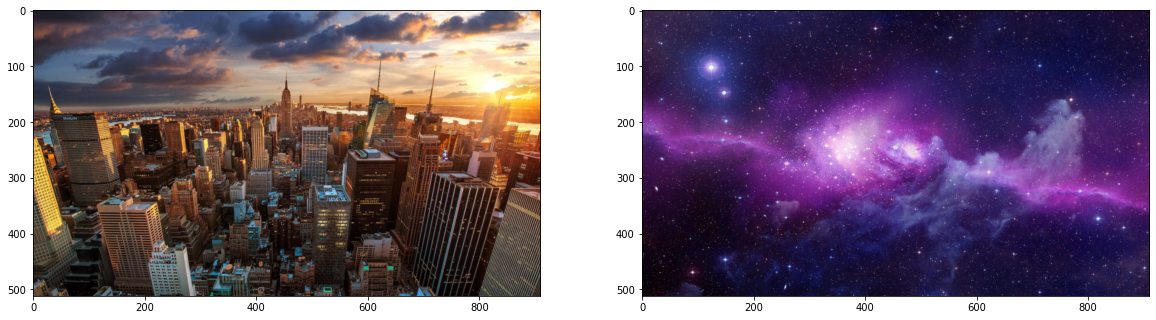

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(display_image(content_image))
ax2.imshow(display_image(style_image))

In [0]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def get_features(image, model, layers=None):
    # Passes the image through all the layers and gets the output after the selected layers
    # and returns a dictionary in the form layer_name: layer_output_features

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2', # Content Representation, rest are style representations
                  '28': 'conv5_1'}

    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    
    return features

In [0]:
def gram_matrix(tensor):
    # This takes in the output of a convolutional layer,
    # ie it is a stack of feature maps in the form of depth x height x width,
    # and returns the gram matrix for that tensor

    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())

    return gram


In [0]:
# Getting the features of each image
content_features = get_features(content_image, vgg)
style_features = get_features(style_image, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Initialize target image
target_image = content_image.clone().requires_grad_(True).to(device)


In [0]:
# Define weights for each style layer (How important each layer is supposed to be)
# and the overall weights for content to style ratio

style_weights = {'conv1_1': 1.,
                  'conv2_1': 0.75,
                  'conv3_1': 0.2,
                  'conv4_1': 0.2,
                  'conv5_1': 0.2}

content_weight = 1
style_weight = 1e6

Total Loss : 1699604480.0 


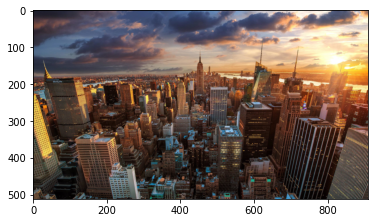

Total Loss : 34476956.0 


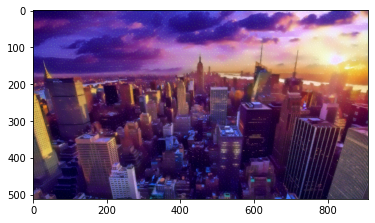

Total Loss : 13228633.0 


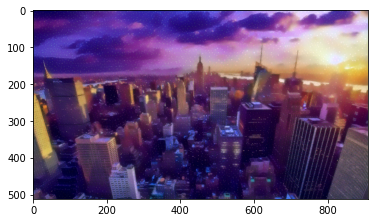

Total Loss : 7830270.0 


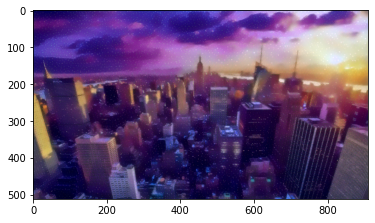

Total Loss : 5078956.0 


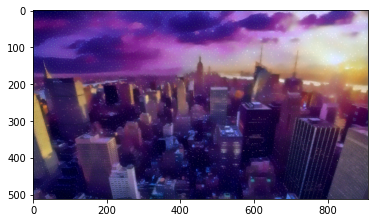

In [0]:
# Training timeee

optimizer = optim.Adam([target_image], lr=0.003)
show_every = 400
steps = 2000

for i in range(steps):
    
    target_features = get_features(target_image, vgg)

    # Content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Style loss
    style_loss = 0
    
    for layer in style_weights:
        # Get the particular target feature
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape

        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        style_loss += layer_style_loss/(d*h*w)

    total_loss = (content_weight*content_loss) + (style_weight*style_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % show_every == 0:
        print('Total Loss : {} '.format(total_loss.item()))
        plt.imshow(display_image(target_image))
        plt.show()


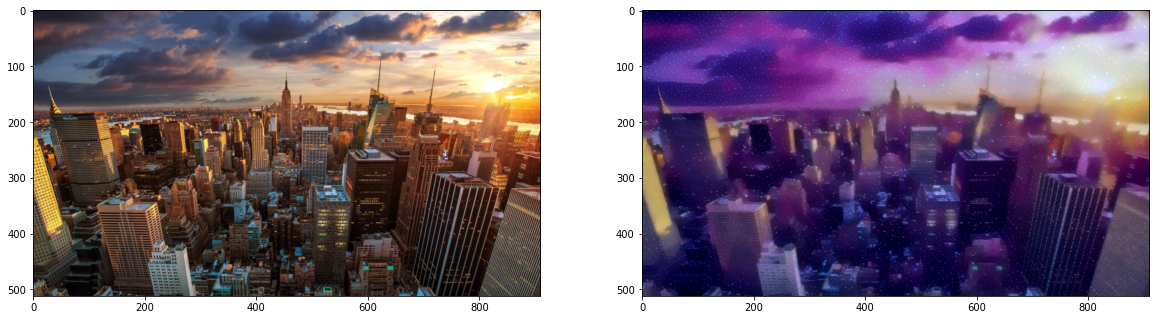

In [0]:
# The new updated target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(display_image(content_image))
ax2.imshow(display_image(target_image))

In [0]:
import matplotlib
matplotlib.image.imsave('styled.jpeg', display_image(target_image))

In [0]:
files.download('styled.jpeg')